In [2]:
import librosa
import numpy as np 
import os
import IPython.display as ipd
from scipy.io import wavfile
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
train_audio_path=r'D:\data\train\audio/'
labels=['yes','no','up','down']

(array([1.500e+01, 7.000e+00, 2.200e+01, 3.700e+01, 1.050e+02, 8.600e+01,
        1.740e+02, 1.340e+02, 2.480e+02, 8.658e+03]),
 array([0.4644375 , 0.51799375, 0.57155   , 0.62510625, 0.6786625 ,
        0.73221875, 0.785775  , 0.83933125, 0.8928875 , 0.94644375,
        1.        ]),
 <BarContainer object of 10 artists>)

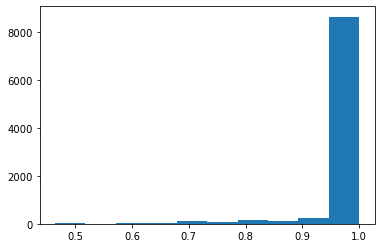

In [36]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [132]:
sample_rate=16000
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = sample_rate)
ipd.Audio(samples, rate=sample_rate)

In [106]:
def make_spec(file, file_dir=train_audio_path, flip=False, ps=False, st = 4):
    """
    create a melspectrogram from the amplitude of the sound
    
    Args:
        file (str): filename
        file_dir (str): directory path
        flip (bool): reverse time axis
        ps (bool): pitch shift
        st (int): half-note steps for pitch shift
    Returns:
        np.array with shape (122,85) (time, freq)
    """
    sig, sr = librosa.load(file_dir+file, sr=16000)
    
    if len(sig) < 16000: #pad shorter than 1 sec audio with ramp to zero
        sig = np.pad(sig, (0,16000-len(sig)), "linear_ramp")
    if ps:
        sig = librosa.effects.pitch_shift(sig, rate, st)
        
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], 
                                             n_fft=512, 
                                             hop_length=128,
                                             center=False),
                               ref=np.max)
    S = librosa.feature.melspectrogram(S=D, n_mels=85).T
    if flip:
        S = np.flipud(S)
    
    return S.astype(np.float32)  
    

In [107]:
spec=make_spec('yes/bfdb9801_nohash_0.wav')

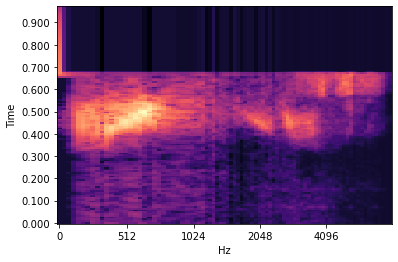

In [108]:
import librosa.display
librosa.display.specshow(spec,
                         x_axis="mel",
                         fmax=8000,
                         y_axis="time",
                         sr=16000,
                         hop_length=128)

In [5]:
all_wave=[]
all_label=[]
for label in labels:
    waves=[f for f in os.listdir(train_audio_path+'/'+label) if f.endswith('.wav')]
    for wav in waves:
        sample,sample_rate=librosa.load(train_audio_path+'/'+label+'/'+wav,sr=16000)
        sample=librosa.resample(sample,sample_rate,8000)
        if (len(sample)==8000):
            all_wave.append(sample)
            all_label.append(label)
    

In [6]:
#one hot_encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(all_label)#label---->number(int)
y

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [22]:
classes= list(le.classes_)
classes

['down', 'no', 'up', 'yes']

In [7]:
from keras.utils import np_utils
y=np_utils.to_categorical(y,num_classes=len(labels))#number--->bits
y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [14]:
all_wave=np.array(all_wave).reshape(-1,8000,1)
all_wave.shape

(8469, 8000, 1)

In [15]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(all_wave,y,stratify=y,test_size=0.2,random_state=777,shuffle=True)

In [17]:
from keras.layers import Dense,Dropout,Flatten,Conv1D,Input,MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import backend as k
k.clear_session()
#Calling clear_session() releases the global state: this helps avoid clutter from old models and layers, especially when memory is limited.

In [19]:
inputs=Input(shape=(8000,1))
#first layer
conv=Conv1D(8,kernel_size=13,padding='valid',activation='relu',strides=1)(inputs)
conv=MaxPooling1D(3)(conv)
conv=Dropout(0.3)(conv)
#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)
#flatten layer
conv=Flatten()(conv)
#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)
#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)
outputs=Dense(len(labels),activation='softmax')(conv)
model=Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [20]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
#early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.0001)
mc=ModelCheckpoint('best_model.hdf5',monitor='val_acc',verbose=1,save_best_only=True,mode='max')

In [68]:
history=model.fit(x_tr,y_tr,epochs=100,callbacks=[es,mc],batch_size=32,validation_data=(x_val,y_val))

Epoch 1/100
212/212 [==============================] - 78s 296ms/step - loss: 1.1508 - accuracy: 0.4828 - val_loss: 0.8437 - val_accuracy: 0.6647
Epoch 2/100
212/212 [==============================] - 29s 136ms/step - loss: 0.7599 - accuracy: 0.7106 - val_loss: 0.6204 - val_accuracy: 0.7674
Epoch 3/100
212/212 [==============================] - 30s 139ms/step - loss: 0.5814 - accuracy: 0.7892 - val_loss: 0.4636 - val_accuracy: 0.8270
Epoch 4/100
212/212 [==============================] - 30s 140ms/step - loss: 0.4996 - accuracy: 0.8125 - val_loss: 0.4106 - val_accuracy: 0.8495
Epoch 5/100
212/212 [==============================] - 30s 139ms/step - loss: 0.4344 - accuracy: 0.8401 - val_loss: 0.4074 - val_accuracy: 0.8566
Epoch 6/100
212/212 [==============================] - 35s 167ms/step - loss: 0.3943 - accuracy: 0.8545 - val_loss: 0.3848 - val_accuracy: 0.8625
Epoch 7/100
212/212 [==============================] - 36s 172ms/step - loss: 0.3535 - accuracy: 0.8770 - val_loss: 0.3596 -

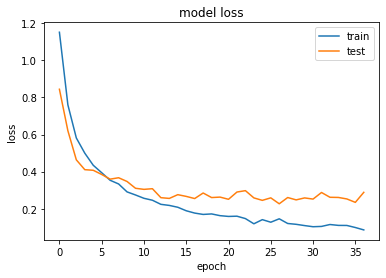

In [89]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

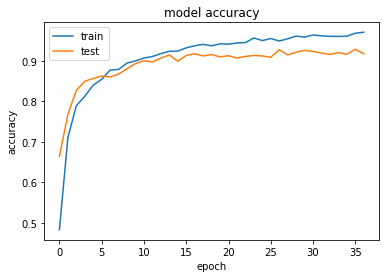

In [90]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [71]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [133]:
import random
index=random.randint(0,len(x_val)-1)
sample=x_val[index].ravel()#Return a contiguous flattened array. A 1-D array, containing the elements of the input
print("audio:",classes[np.argmax(y_val[index])])
ipd.Audio(sample,rate=8000)

audio: down


In [134]:
print("text:",predict(sample))

1/1 [==============================] - 1s 701ms/step
text: down


In [85]:
y_hat=model.predict(x_val)
y_true=y_val
y_hat = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_true, axis=-1)

53/53 [==============================] - 6s 89ms/step


In [80]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
from sklearn.metrics import f1_score as f1_score_rep
import seaborn as sn
import pandas as pd

In [104]:

def print_score(y_pred, y_real, label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print("Precision:: ", precision_score(y_real, y_pred, average="micro"))
    print("Recall:: ", recall_score(y_real, y_pred, average="micro"))
    print("F1_Score:: ", f1_score_rep(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (macro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="macro"))
    
    print()
    print("Macro precision_recall_fscore_support (micro) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="micro"))

    print()
    print("Macro precision_recall_fscore_support (weighted) average")
    print(precision_recall_fscore_support(y_real, y_pred, average="weighted"))
    print()
    print()
    print("Classification Report")
    print(classification_report(y_real, y_pred, target_names=label_encoder))
    print("Confusion Matrix")
    cm = confusion_matrix(y_real, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i for i in label_encoder],
                  columns = [i for i in label_encoder])
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cm, annot=True)

   
    

Accuracy:  0.9173553719008265
Precision::  0.9173553719008265
Recall::  0.9173553719008265
F1_Score::  0.9173553719008265

Macro precision_recall_fscore_support (macro) average
(0.9182012083401188, 0.9175837523489364, 0.9173234802332976, None)

Macro precision_recall_fscore_support (micro) average
(0.9173553719008265, 0.9173553719008265, 0.9173553719008265, None)

Macro precision_recall_fscore_support (weighted) average
(0.9182644634639391, 0.9173553719008265, 0.9172381527701632, None)


Classification Report
              precision    recall  f1-score   support

        down       0.96      0.89      0.92       430
          no       0.91      0.89      0.90       420
          up       0.91      0.96      0.94       412
         yes       0.89      0.94      0.91       432

    accuracy                           0.92      1694
   macro avg       0.92      0.92      0.92      1694
weighted avg       0.92      0.92      0.92      1694

Confusion Matrix


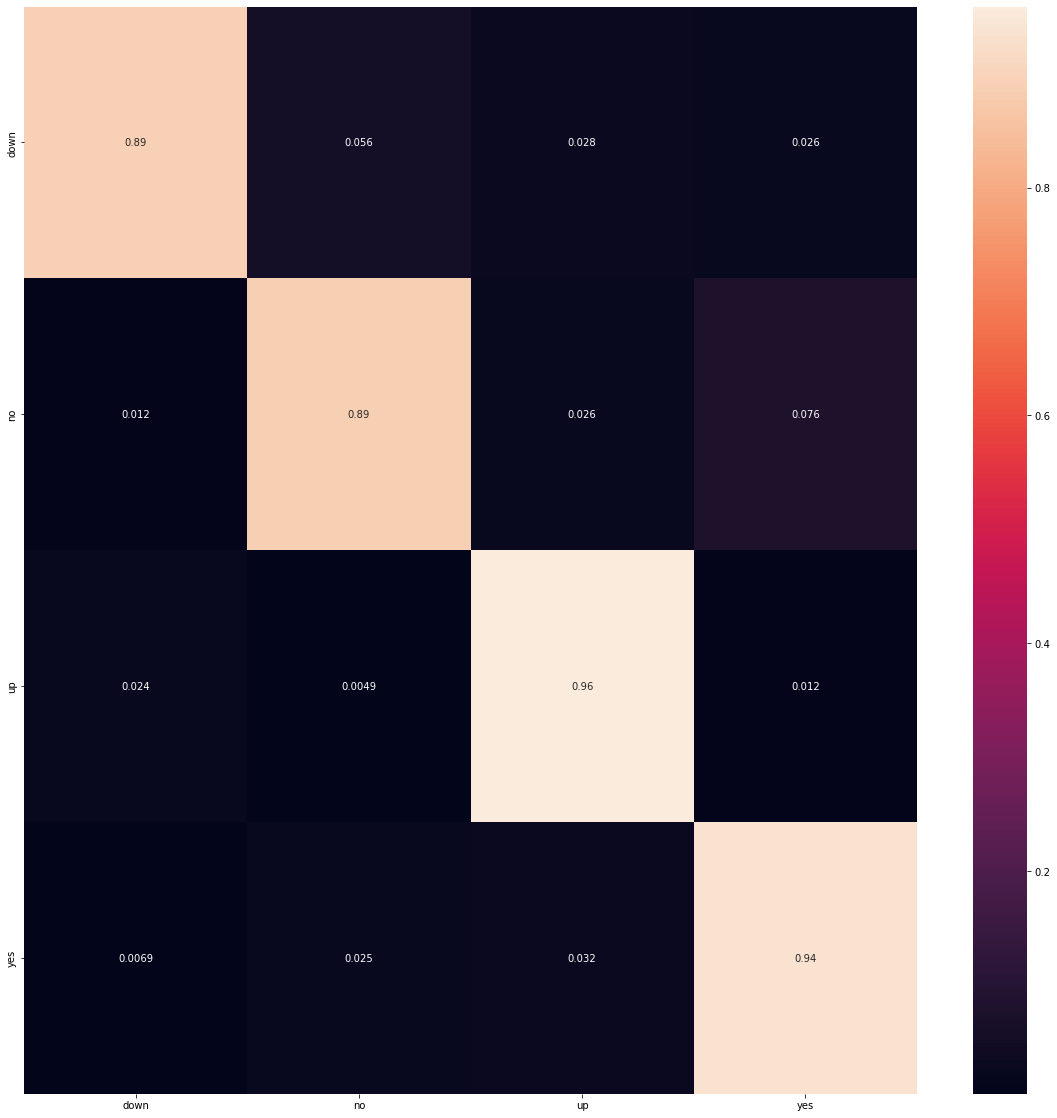

In [105]:
print_score(y_hat, y_true, classes)